<h1>LightMat Tutorial: Density of Bose gas and Fermi gas in arbitrary trap potential</h1>

In this tutorial, it is shown how to calculate the spatial density of an atomic gas in some arbitrary potential. This potential could either be a 3d array, for example coming from a LightMat calculation of some LaserSetup (see single atom tutorial) or it could also be just a self-written callable function. 

In [1]:
from LightMat import BoseGas, FermiGas, ParticleProps, GaussianBeam, Atom, LaserSetup, interactive_plot
from LightMat.many_body.spatial_basis import GridSpatialBasisSet
import numpy as np
import astropy.units as u
from astropy.constants import h, k_B
from typing import Union

<h2>1) Self-written callable potential function</h2>
Let us first discuss how to set up a callable potential function in which the density of some atomic gas should be calculated. As an example, we can just set up a harmonic potential in all 3 directions with some random noise on it to see how it affects the density.

In [2]:
np.random.seed(42)

def harmonic_trap(
        x: Union[float, np.ndarray, u.Quantity],
        y: Union[float, np.ndarray, u.Quantity],
        z: Union[float, np.ndarray, u.Quantity],
        trap_depth: Union[float, u.Quantity] = 200*u.nK,
        waist: Union[float, u.Quantity] = 50*u.um,
        inhomogenity: float = 0,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]. Can either be just scalars or arrays obtained from np.meshgrid().
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 50μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude. Defaults to 0.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z.
    """
    if isinstance(x, u.Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, u.Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, u.Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, u.Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(waist, u.Quantity) and waist.unit.is_equivalent(u.um):
        waist = waist.to(u.um).value

    # Create Gaussian profile for isotropc 3d harmonic trap
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)

    # Apply the potential: -trap_depth at the center, 0 at the edges
    perfect_harmonic_trap = -trap_depth * gaussian_profile

    # Add noise
    noise = np.random.rand(*perfect_harmonic_trap.shape, ) * inhomogenity * trap_depth

    return perfect_harmonic_trap + noise

<h3>Set up particle properties</h3>

Now we want to set up some properties of the particles for which we want to calculate the spatial density. This also includes also the potential that is seen by the particles, for example the harmonic potential defined above. 

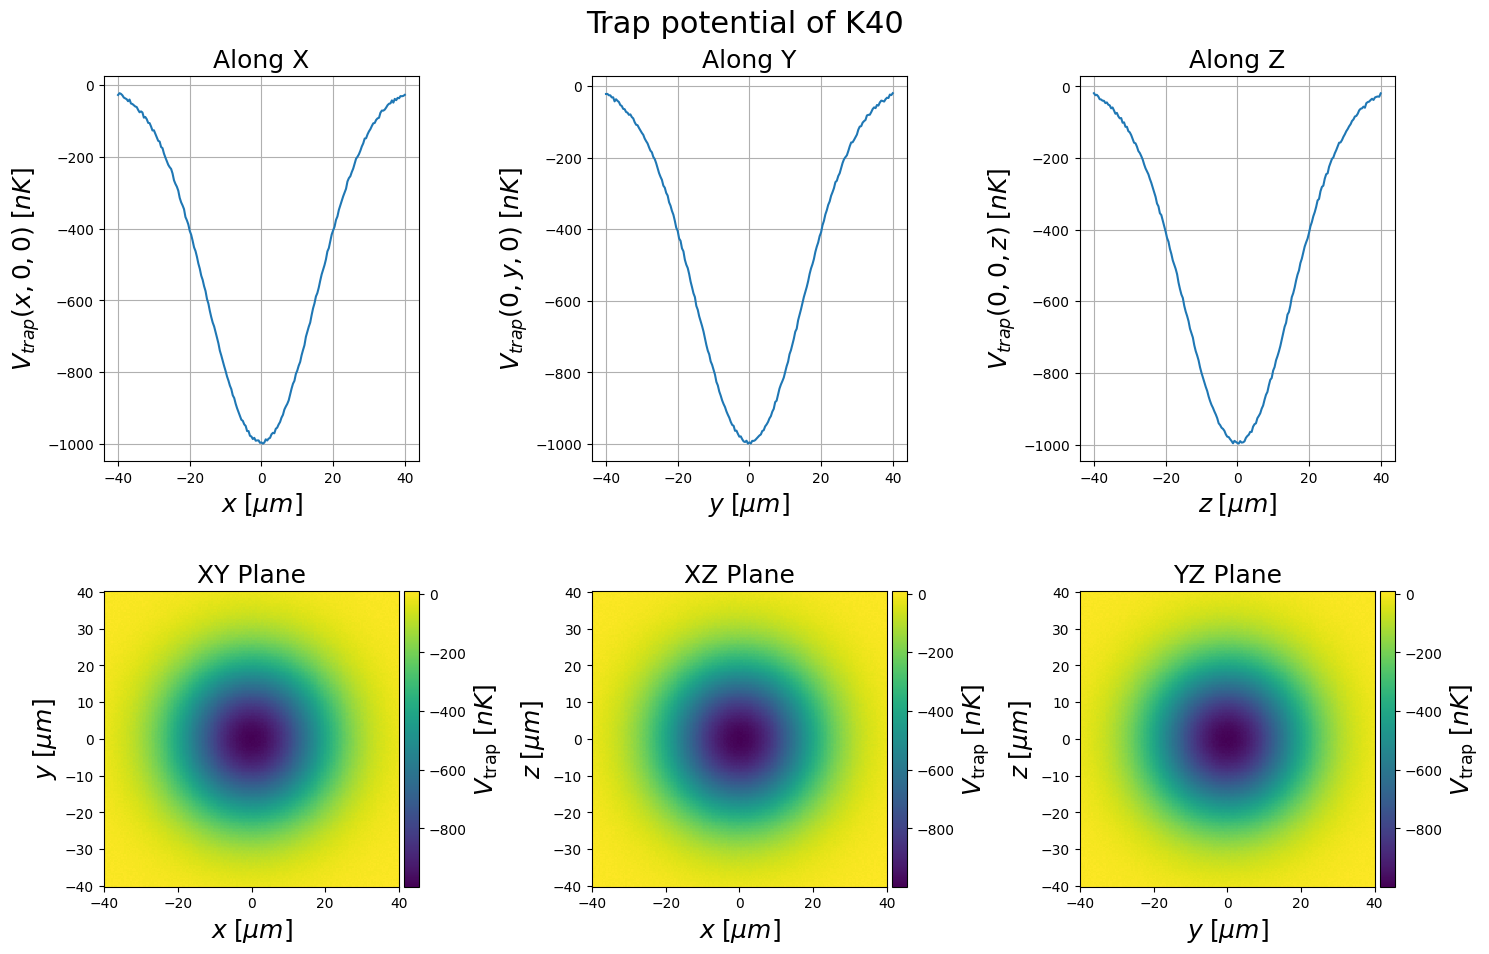

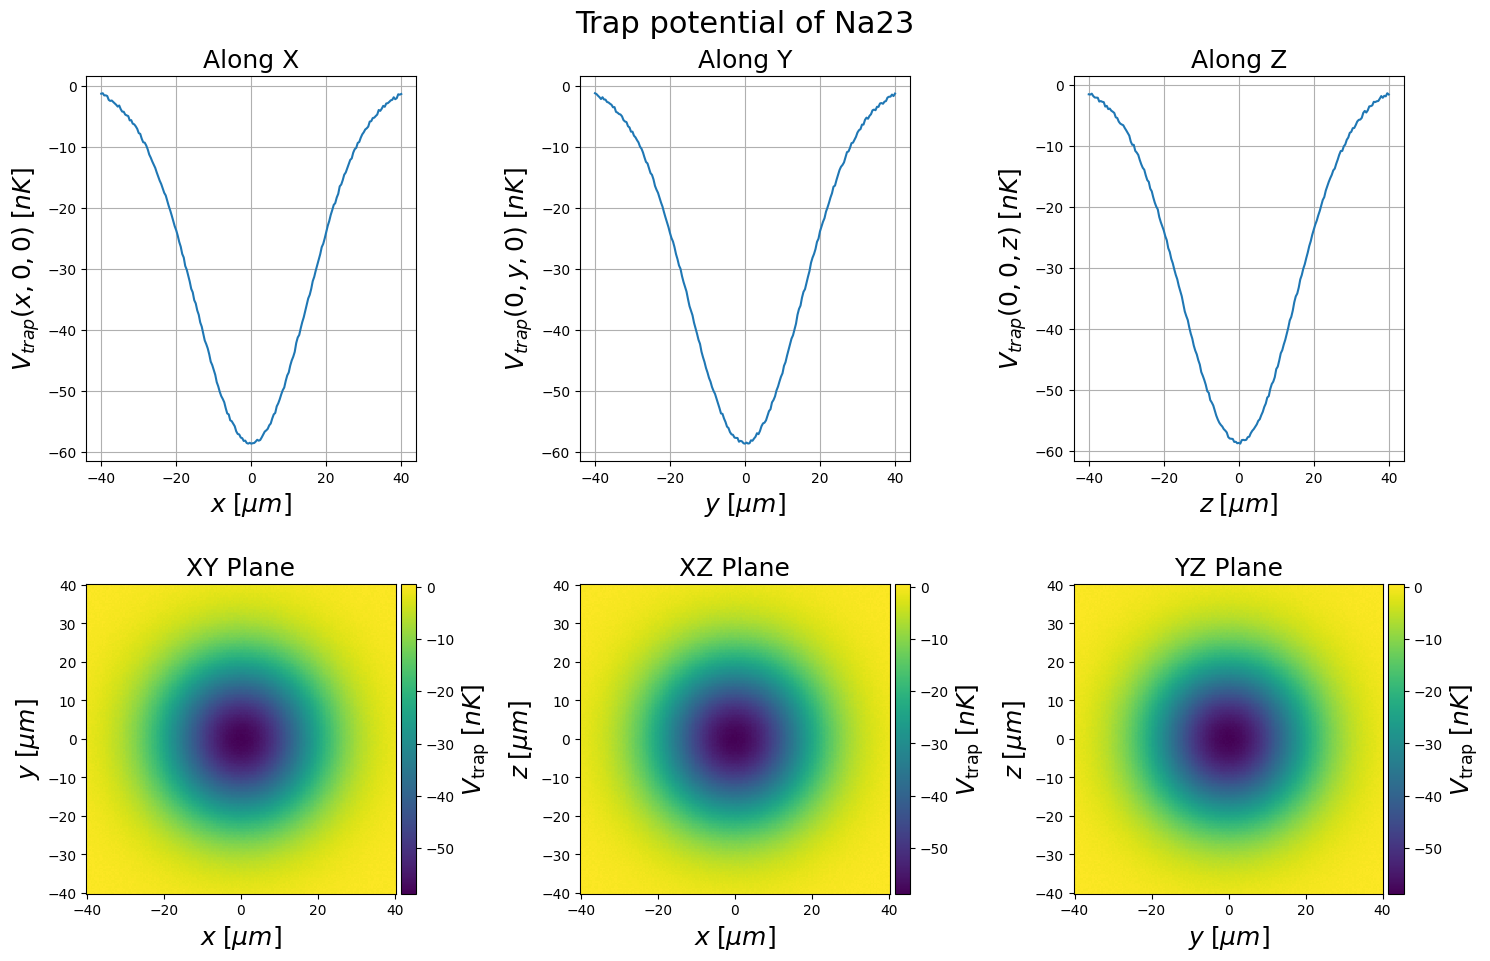

In [3]:
k40_harmonic = ParticleProps(
    name="K40", # this is just a label, it does not need to be provided. Default is "Particle"
    species="fermion", # boson or fermion
    m=39.963999*u.u, # mass of the atomic particles, either as float (assumed to be in [kg]) or as astropy.Quantity in units of mass
    N_particles=100000, # number of particles in the gas. The chemical potential will later be chosen such that the density is normalized to N_particles
    T=0*u.nK, # temperature of the gas, either as float (assumed to be in [nK]) or as astropy.Quantity in units of temperature
    domain=(-40, 40)*u.um, 
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap_func=harmonic_trap, 
    trap_depth=1000*u.nK, # kwarg of harmonic_trap()
    waist=30*u.um, # kwarg of harmonic_trap()
    inhomogenity=0.01, # kwarg of harmonic_trap(). Let's put 1% random noise on the light intensity
)

na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=100000,
    T=0*u.nK,
    a_s=2.75*u.nm, # s-wave scattering length, either as float (assumed to be in [m]) or as astropy.Quantity in units of length (note that this only enters
                   # for bosons, identical fermions cannot interact by s-wave scattering due to Pauli blocking and are assumed to be non-interacting at low energy)
    domain=(-40, 40)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap_func=harmonic_trap,
    trap_depth=k40_harmonic.trap_depth / 17, # suppose the trap comes from 780nm light, then the trap depth for Na23 is 17 times smaller than for K40
    waist=30*u.um, # kwarg of harmonic_trap()
    inhomogenity=0.01, # kwarg of harmonic_trap(). Let's put 1% random noise on the light intensity
)

k40_harmonic.plot_V_trap()
na23_harmonic.plot_V_trap()

<h3>Calculate density at T=0</h3>

Next, we can setup a FermiGas() object for K40 and a BoseGas object for Na23. This has then the method eval_density(), for which all sorts of parameters can be specified, for more information just hover over eval_density().

In [4]:
fg_harmonic = FermiGas(k40_harmonic)
fg_harmonic.eval_density(use_TF_or_LDA=False) # Setting this False will use energy functional minimization (currently only works at zero temperature)

bg_harmonic = BoseGas(na23_harmonic) 
bg_harmonic.eval_density(use_TF=False) # Setting this False will use energy functional minimization (currently only works at zero temperature)

Initial n is calculated with the TF approximation. Afterwards functional energy minimization will be performed...


  6%|▌         | 60/1000 [00:01<00:18, 52.16it/s]


Convergence reached after 60 iterations.
Initial n0 is calculated with the TF approximation. Afterwards functional energy minimization will be performed...


 51%|█████     | 51/100 [00:01<00:01, 34.00it/s]

Convergence reached after 51 iterations.


<h3>Plot density</h3>

The array of the density can be found as fg.n_array or bg.n_array (also condensed and thermal densities of the Bose gas can be found by bg.n0_array and bg.n_ex_array, but at zero temperature n=n0 and n_ex=0)

The density array can however also just be directly plotted by using the plot_density_1d() or plot_density_2d() methods. These methods return the figure, so the plot can be adjusted afterwards by manipulating the Figure() object from matplotlib.

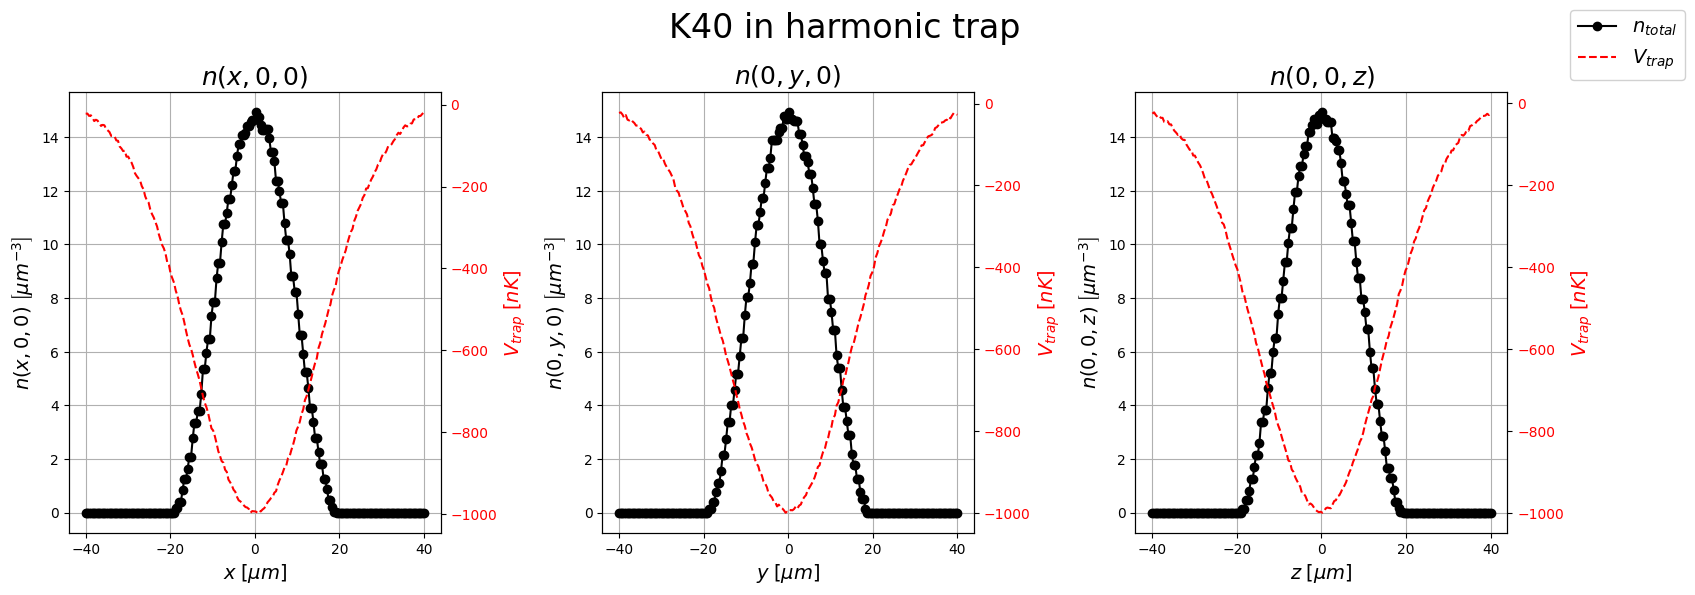

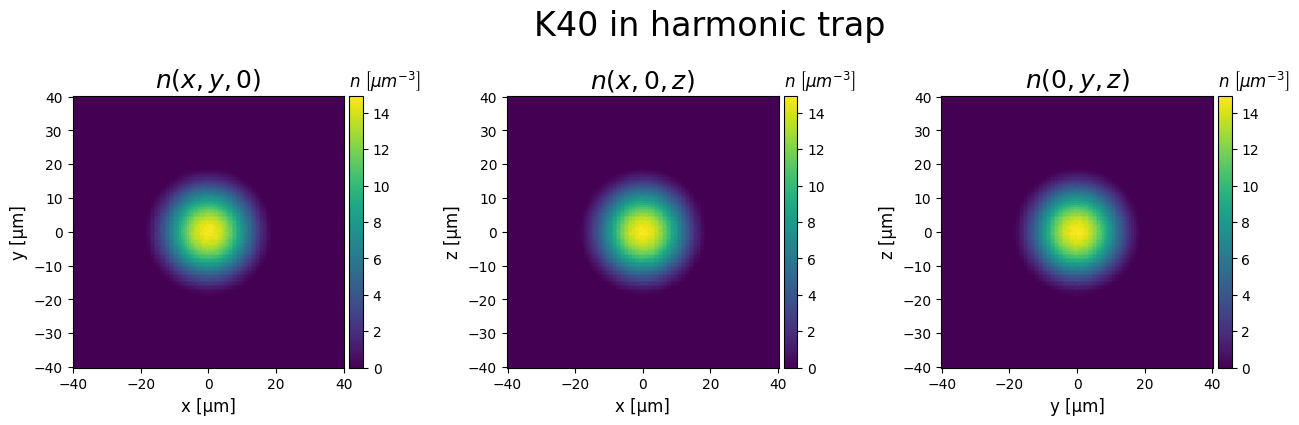

In [5]:
fig_bg = fg_harmonic.plot_density_1d(title="K40 in harmonic trap") 
fig_bg = fg_harmonic.plot_density_2d(title="K40 in harmonic trap") 

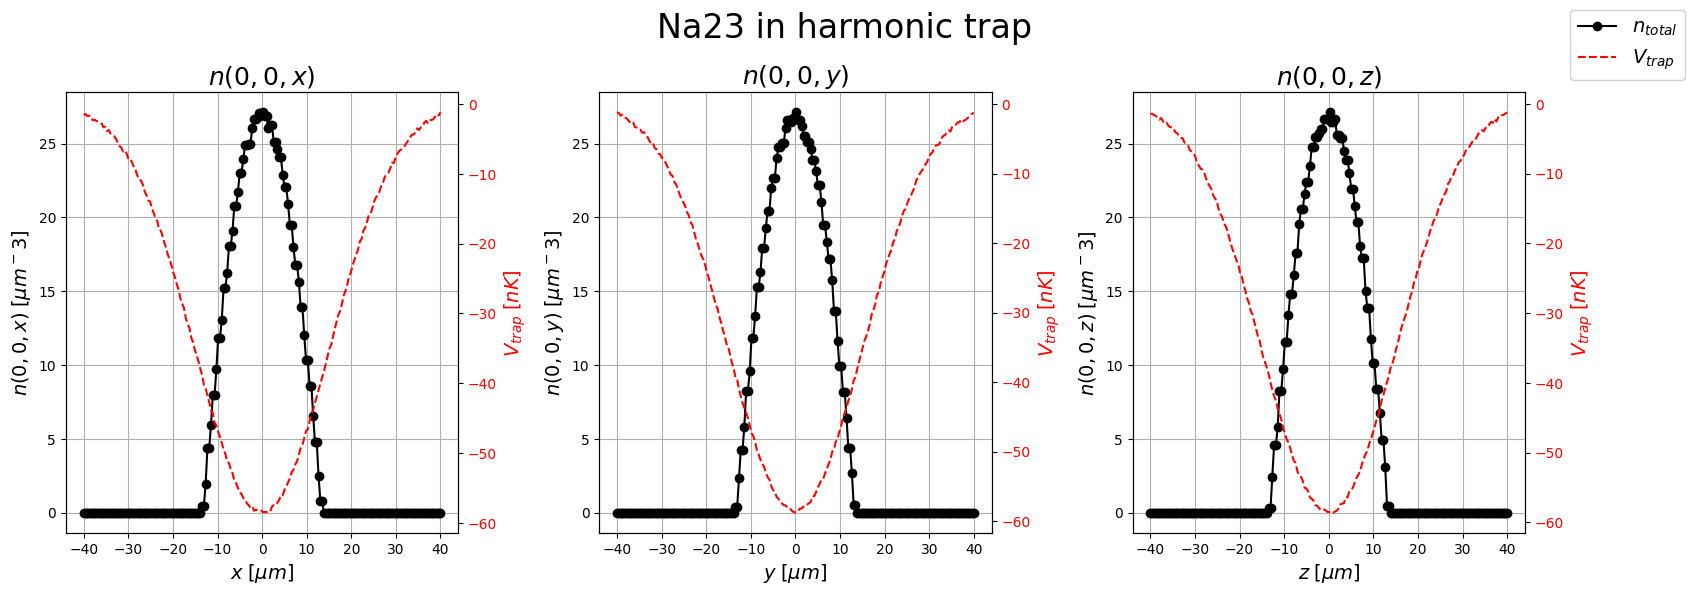

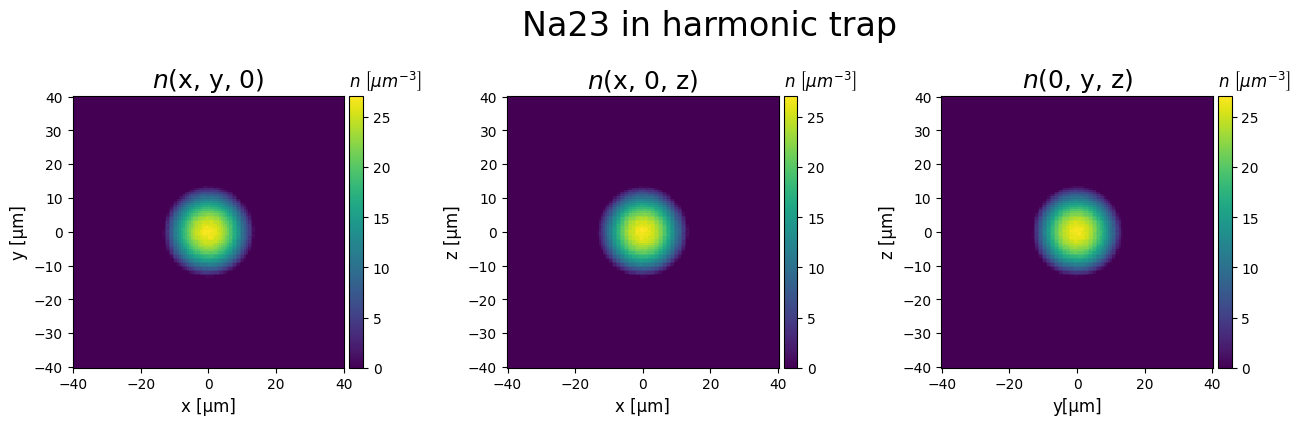

In [6]:
fig_fg = bg_harmonic.plot_density_1d(which='n', title="Na23 in harmonic trap") # the density plot methods of the BoseGas() have an additional 'which' parameter
fig_fg = bg_harmonic.plot_density_2d(which='n', title="Na23 in harmonic trap") # that can be ['all', 'n', 'n0', 'n_ex'] to select which density to plot

<h3>Analysis</h3>

We see that the 1% noise is not very important for the harmonic trap, the density still looks very Gaussian both for fermionic K40 and bosonic Na23. The bosonic density is more narrow and has consequently a higher peak even though the trap depth is 17 times smaller than for K40 - this comes from the bosonic nature of Na23 forming a perfect BEC at T=0.

Note that a perefect isotropic harmonic trap is not realistic, in order to get some more realistic potentials one could use the potential calculated by LigthMat based on some laser setup as shown in the tutorial_single_atom.ipynb notebook.

<h2>2) Potential function from LightMat based on LaserSetup()</h2>

Let us set up two Gaussian beams forming a crossed dipole trap and then calculate the spatial density of K40 and Na23 in the potential they feel due to these beams.

In [7]:
beam1 = GaussianBeam(
    beam_direction_vec=(1,0,0), 
    lambda_ = 1064 * u.nm,  
    w0 = 0.5 * u.mm, 
    P = 10 * u.W,
    pol_Jones_vec='linear horizontal',
    name='Beam 1', 
)

beam2 = GaussianBeam(
    beam_direction_vec=(1,1,0), 
    lambda_ = 1064 * u.nm,  
    w0 = 0.5 * u.mm, 
    P = 10 * u.W,
    pol_Jones_vec='linear vertical',
    name='Beam 2', 
)

Next, let us set up a K40 atom and a Na23 atom in a hyperfine groundstate

In [8]:
K40 = Atom(
    hfs_state={'n': 4, 'L': 's', 'J': 1/2, 'F': 9/2, 'mF': -9/2, 'I': 4,}, 
    name='K', 
)

Na23 = Atom(
    hfs_state={'n': 3, 'L': 's', 'J': 1/2, 'F': 3, 'mF': -3, 'I': 3/2,}, 
    name='Na', 
)

Now we can define a laser setup for K40 and for Na23 in order to get a potential function they feel due to the crossed dipole trap.

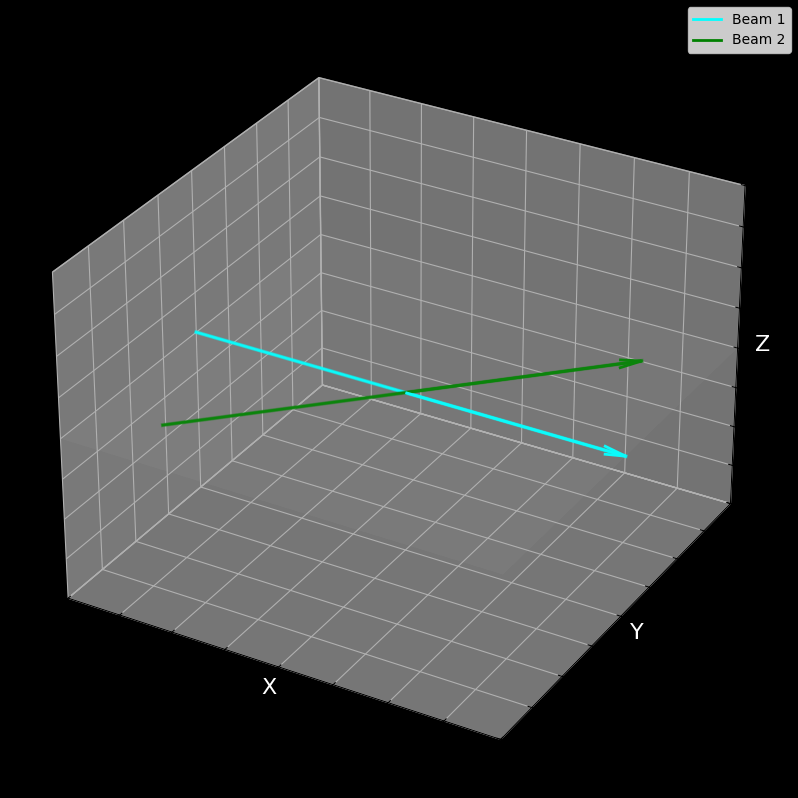

In [9]:
n = 101

setup_K40 = LaserSetup(
    lasers=[beam1, beam2],
    atoms=K40,
)

setup_Na23 = LaserSetup(
    lasers=[beam1, beam2],
    atoms=Na23,
)

setup_K40.plot_beams() # this is the same as for Na23, both setups have the same beams

Let's take a look at the crossed dipole trap potential felt by K40 and by Na23 due to these laser beams

In [ ]:
x = np.linspace(-1, 1, n) * u.mm 
y = np.linspace(-1, 1, n) * u.mm
z = np.linspace(-1, 1, n) * u.mm 

X, Y, Z = np.meshgrid(x, y, z, indexing='ij') # these are arrays of shape (n,n,n) containing the grid points for our spatial region


V_K40_array_3d = setup_K40.V(X, Y, Z) # this will return the potential in [k_B x nK] at the grid points (X,Y,Z)
V_Na23_array_3d = setup_Na23.V(X, Y, Z)

interactive_plot(
    [V_K40_array_3d, V_Na23_array_3d],
    x, y, z, # in our case the x, y, z coordinates are the same for both gases, so this works
    title=['K40 crossed dipole trap', 'Na23 crossed dipole trap'],
    cbar_title='V [kB x nK]',
)

Output()

Now we can again set up particle properties for the K40- and Na23-gas, but this time we provide setup.V as potential function.

In [11]:
k40_crossed_dipole_trap = ParticleProps(
    name="K40", 
    species="fermion", 
    m=39.963999*u.u, 
    N_particles=100000, 
    T=0*u.nK, 
    domain=(-100, 100)*u.um, 
    V_trap_func=setup_K40.V,
    unit = u.nK, # kwarg of LaserSetup.V(), the unit of the potential must be in [k_B x nK] for the ParticleProps() to work
)

na23_crossed_dipole_trap = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=100000,
    T=0*u.nK,
    a_s=2.75*u.nm,
    domain=(-100, 100)*u.um,
    V_trap_func=setup_Na23.V,
    unit = u.nK, # kwarg of LaserSetup.V(), the unit of the potential must be in [k_B x nK] for the ParticleProps() to work
)

Next, we can set up the FermiGas() and BoseGas() objects for K40 and Na23 respectively. Let us then quickly take a look at the potential for K40 and Na23 using the interactive plot.

In [12]:
fg_crossed_dipole_trap = FermiGas(k40_crossed_dipole_trap, spatial_basis_set="grid", num_grid_points=n)
bg_crossed_dipole_trap = BoseGas(na23_crossed_dipole_trap, spatial_basis_set="grid", num_grid_points=n)

fg_crossed_dipole_trap.eval_density(use_TF_or_LDA=False) 
bg_crossed_dipole_trap.eval_density(use_TF=False) 

Initial n is calculated with the TF approximation. Afterwards functional energy minimization will be performed...


  4%|▍         | 42/1000 [00:01<00:35, 27.19it/s]


Convergence reached after 42 iterations.
Initial n0 is calculated with the TF approximation. Afterwards functional energy minimization will be performed...


 40%|████      | 40/100 [00:01<00:02, 26.38it/s]

Convergence reached after 40 iterations.


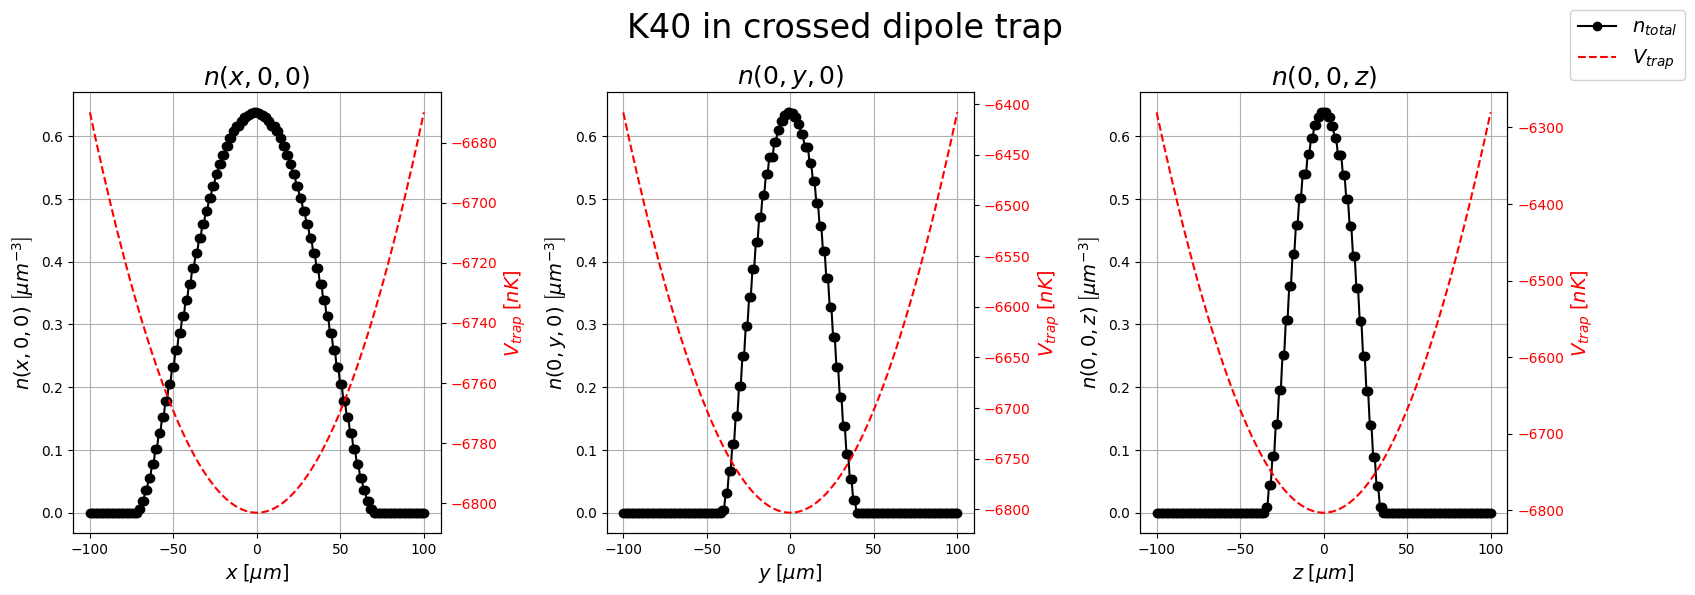

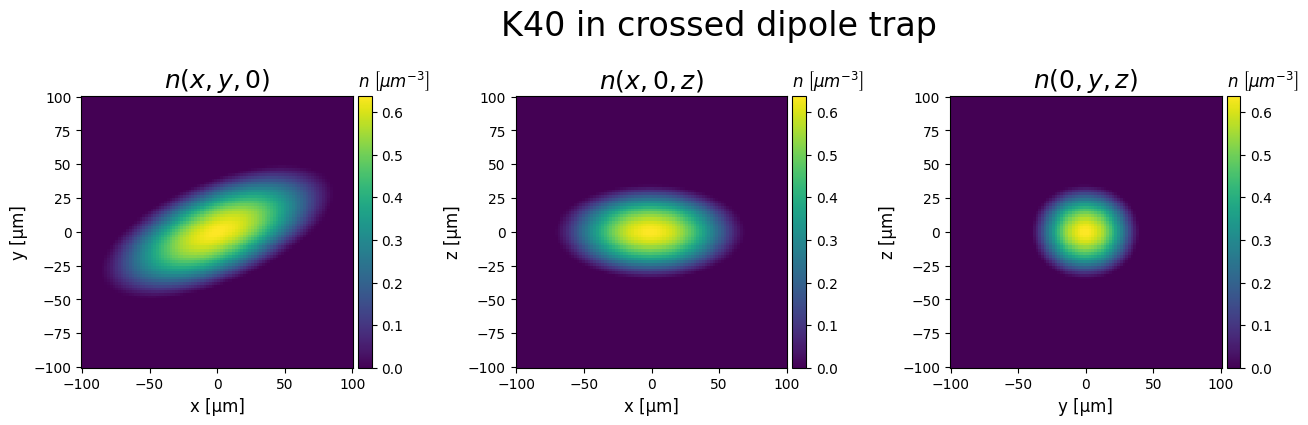

In [13]:
fig_bg = fg_crossed_dipole_trap.plot_density_1d(title="K40 in crossed dipole trap") 
fig_bg = fg_crossed_dipole_trap.plot_density_2d(title="K40 in crossed dipole trap") 

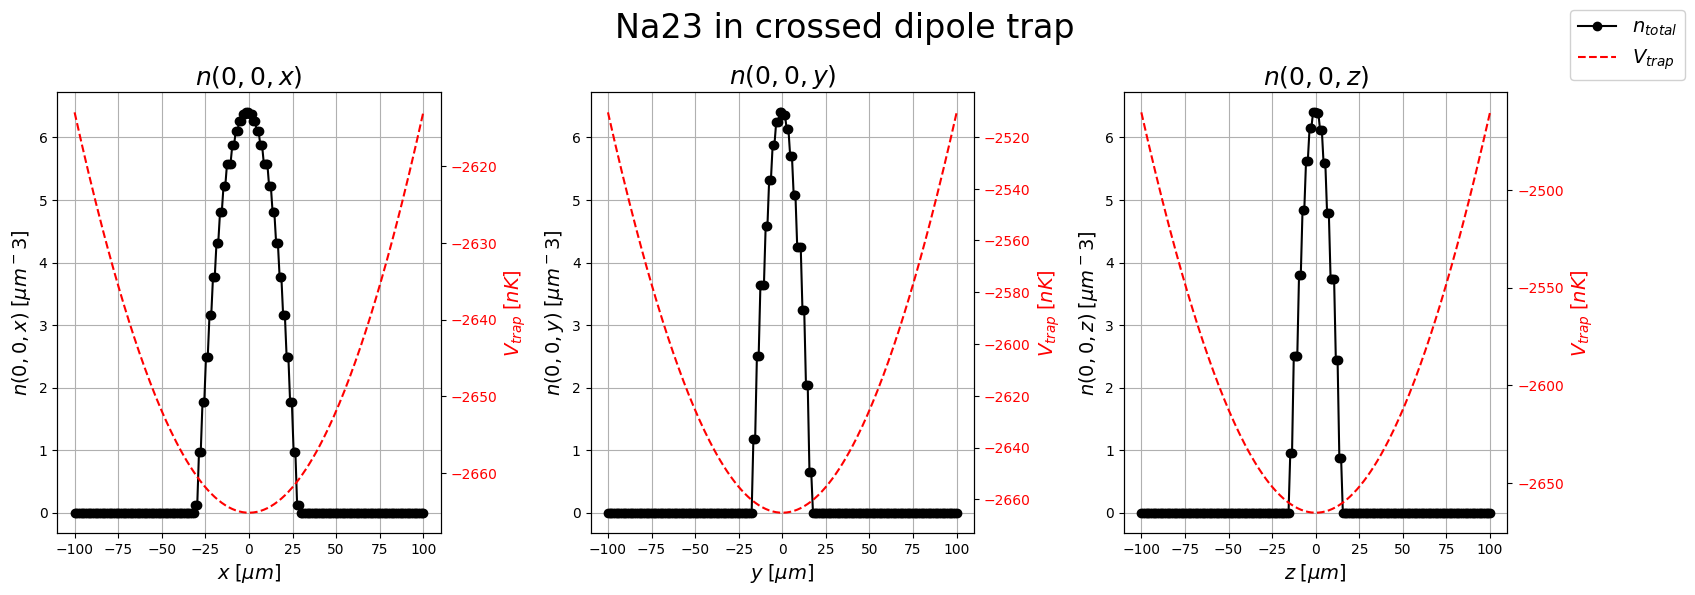

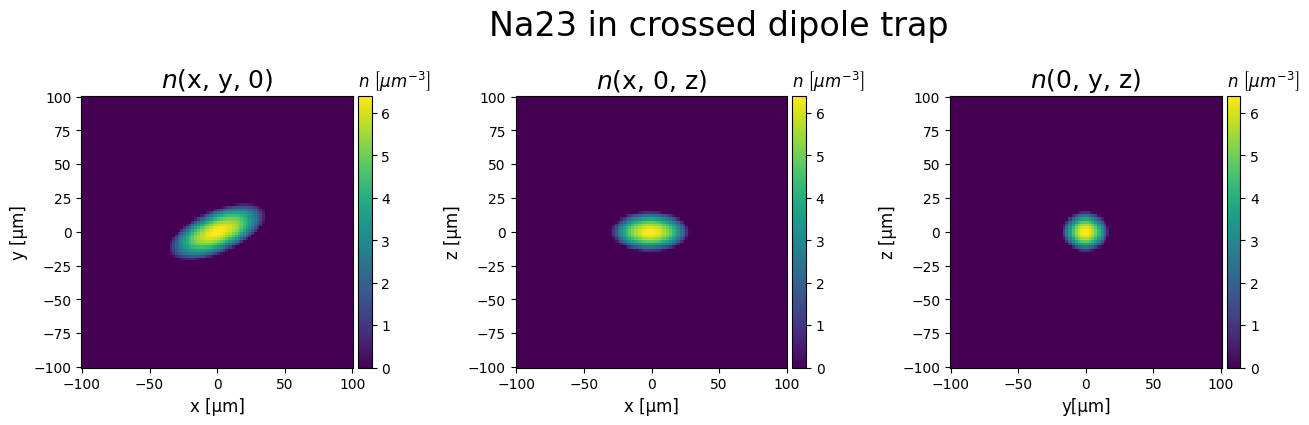

In [14]:
fig_fg = bg_crossed_dipole_trap.plot_density_1d(which='n', title="Na23 in crossed dipole trap") 
fig_fg = bg_crossed_dipole_trap.plot_density_2d(which='n', title="Na23 in crossed dipole trap")

<h3>Analysis</h3>

We can see the density in the crossed dipole trap. As expected for the bosonic gas it is more peaked than for the fermionic gas, because it forms a BEC.